# <center>LLM - Detect AI Generated Text</center>

This competition challenges participants to develop a machine learning model that can accurately detect **whether an essay was written by a student or an LLM**. The competition dataset comprises a mix of student-written essays and essays generated by a variety of LLMs.

Team Members: 毛柏毅, 朱誼學, 許木羽, 張立誠

In [1]:
# %pip install transformers
# %pip install peft
# %pip install bitsandbytes
# %pip install accelerate
# %pip install omegaconf
# %pip install lightgbm

## Configuration

In [49]:
import transformers as T
from datasets import Dataset
import torch
# from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
import torch.nn as nn
import torch.nn.functional as F
import kagglehub
import numpy as np

import os
import gc
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display, HTML

In [3]:
from typing import Literal

HOST: Literal['Localhost', 'Interactive', 'Batch'] = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', 'Localhost')
IS_RERUN: bool = os.getenv('KAGGLE_IS_COMPETITION_RERUN')

print(f'HOST: {HOST}, IS_RERUN: {IS_RERUN}')

HOST: Localhost, IS_RERUN: None


In [4]:
device = torch.device(
    ("cuda:3" if torch.cuda.is_available()
     else "mps" if torch.backends.mps.is_available()
     else "cpu"))

## Data

In [5]:
def get_kaggle_csv(dataset: str, name: str, is_comp: bool = False) -> pd.DataFrame:
    assert name.endswith('.csv')
    if IS_RERUN:
        return pd.read_csv(f'/kaggle/input/{dataset}/{name}')
    if is_comp:
        path = kagglehub.competition_download(dataset)
    else:
        path = kagglehub.dataset_download(dataset)
    return pd.read_csv(Path(path) / name)

In [6]:
if IS_RERUN:
    df_train = get_kaggle_csv('daigt-datamix', 'train_essays.csv')
    df_test = get_kaggle_csv('llm-detect-ai-generated-text', 'test_essays.csv', is_comp=True)
else:
    df_train = get_kaggle_csv('dogeon188/daigt-datamix', 'train_essays.csv')
    # split df_train into train and test
    df_train = df_train.sample(frac=1).reset_index(drop=True)
    df_test = df_train.iloc[-2000:]
    df_train = df_train.iloc[:20000]
df_train = df_train[df_train['source'] != 'unknown']

## Model

### Preprocess Data

In [7]:
from transformers import PreTrainedTokenizerFast
from tokenizers import Tokenizer, models, normalizers, pre_tokenizers, trainers

VOCAB_SIZE = 30000
LOWERCASE = False

raw_tokenizer = Tokenizer(models.BPE(unk_token="[UNK]"))
raw_tokenizer.normalizer = normalizers.Sequence(
    [normalizers.NFC()] + [normalizers.Lowercase()] if LOWERCASE else [])
raw_tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel()
special_tokens = ["[UNK]", "[PAD]", "[CLS]", "[SEP]", "[MASK]"]
trainer = trainers.BpeTrainer(
    vocab_size=VOCAB_SIZE, special_tokens=special_tokens)

ds_test = Dataset.from_pandas(df_test[['text']])
ds_train = Dataset.from_pandas(df_train[['text']])


def train_corp_iter():
    for i in range(0, len(ds_test), 1000):
        yield ds_test[i: i + 1000]["text"]
    # for i in range(0, len(ds_train), 1000):
    #     yield ds_train[i: i + 1000]["text"]


raw_tokenizer.train_from_iterator(
    train_corp_iter(),
    trainer=trainer,
    # length=len(ds_test) + len(ds_train)
)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=raw_tokenizer,
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]",
)

tokenized_texts_test = [tokenizer.tokenize(text)
                        for text in tqdm(df_test['text'])]
tokenized_texts_train = [tokenizer.tokenize(text)
                         for text in tqdm(df_train['text'])]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
100%|██████████| 49998/49998 [00:39<00:00, 1268.75it/s]


### TFIDF

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer


def dummy(x): return x


vectorizer = TfidfVectorizer(
    ngram_range=(3, 5), lowercase=False, sublinear_tf=True, analyzer='word',
    tokenizer=dummy, preprocessor=dummy,
    token_pattern=None, strip_accents='unicode')

vectorizer.fit(tqdm(tokenized_texts_test))

# Getting vocab
vocab = vectorizer.vocabulary_

vectorizer = TfidfVectorizer(
    ngram_range=(3, 5), lowercase=False, sublinear_tf=True, vocabulary=vocab,
    analyzer='word', tokenizer=dummy, preprocessor=dummy,
    token_pattern=None, strip_accents='unicode'
)

tf_train = vectorizer.fit_transform(tqdm(tokenized_texts_train))
tf_test = vectorizer.transform(tqdm(tokenized_texts_test))

del vocab, vectorizer, tokenized_texts_train, tokenized_texts_test
gc.collect()

100%|██████████| 10000/10000 [00:07<00:00, 1379.19it/s]


0

In [16]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score


def run_eval_generated():
    y_train = df_train['generated']

    clf = MultinomialNB(alpha=0.02)

    sgd_model = SGDClassifier(max_iter=8000, tol=1e-4, loss="modified_huber")

    LGB_N_ITER = 100 if IS_RERUN else 3
    lgb = LGBMClassifier(
        n_estimators=LGB_N_ITER,
        num_leaves=51,
        objective='binary',
        metric='roc_auc',
        learning_rate=0.05,
        colsample_bytree=0.7,
        colsample_bynode=0.6,
        lambda_l1=8,
        lambda_l2=5,
        num_threads=4,
        min_data_in_leaf=10,
        max_depth=20,
        max_bin=900,
        verbose=-1,
    )

    clf.fit(tf_train, y_train)
    p1 = clf.predict_proba(tf_test)[:, 1]
    print("NB Done!")

    sgd_model.fit(tf_train, y_train)
    p2 = sgd_model.predict_proba(tf_test)[:, 1]
    print("SGD Done!")

    pbar = tqdm(total=LGB_N_ITER)
    lgb.fit(tf_train, y_train, callbacks=[lambda _: pbar.update(1)])
    p3 = lgb.predict_proba(tf_test)[:, 1]
    print("LGBM Done!")
    pbar.close()

    final_preds = p1 * 0.1 + p2 * 0.45 + p3 * 0.45


    auc_score = roc_auc_score(df_test['generated'], final_preds)
    
    print(f"ROC AUC: {auc_score:.4f}")

In [17]:
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss, roc_auc_score

def run_eval(CLASS_HUMAN_FACTOR: int = 1):
    y_train = df_train['source']

    clf = MultinomialNB(alpha=0.02)

    class_weight = df_train['source'].value_counts(normalize=True).to_dict()
    class_weight['human'] *= CLASS_HUMAN_FACTOR
    class_weight = {k: v / sum(class_weight.values()) for k, v in class_weight.items()}

    sgd_model = SGDClassifier(
        max_iter=8000,
        tol=1e-4,
        loss="modified_huber",
        class_weight=class_weight,
    )

    LGB_N_ITER = 100 if IS_RERUN else 3
    lgb = LGBMClassifier(
        n_estimators=LGB_N_ITER,
        num_leaves=51,
        objective='multiclass',
        metric='multi_logloss',
        learning_rate=0.05,
        colsample_bytree=0.7,
        colsample_bynode=0.6,
        lambda_l1=8,
        lambda_l2=5,
        num_threads=4,
        min_data_in_leaf=10,
        max_depth=20,
        max_bin=900,
        verbose=-1,
        class_weight=class_weight,
    )

    clf.fit(tf_train, y_train)
    human_idx = np.where(clf.classes_ == 'human')[0][0]
    print("NB Done!")

    sgd_model.fit(tf_train, y_train)
    human_idx = np.where(sgd_model.classes_ == 'human')[0][0]
    print("SGD Done!")

    pbar = tqdm(total=LGB_N_ITER)
    lgb.fit(tf_train, y_train, callbacks=[lambda x: pbar.update(1)])
    human_idx = np.where(lgb.classes_ == 'human')[0][0]
    print("LGBM Done!")


    # examine the predictions
    p1 = clf.predict_proba(tf_test)
    p2 = sgd_model.predict_proba(tf_test)
    p3 = lgb.predict_proba(tf_test)
    final_preds = p1*0.1 + p2*0.45 + p3*0.45
    
    # calculate the final score
    mc_score = log_loss(df_test['source'], final_preds)

    p1 = p1[:, np.where(clf.classes_ == 'human')[0][0]]
    p2 = p2[:, np.where(sgd_model.classes_ == 'human')[0][0]]
    p3 = p3[:, np.where(lgb.classes_ == 'human')[0][0]]
    final_preds = p1*0.1 + p2*0.45 + p3*0.45
    final_preds = 1 - final_preds
    auc_score = roc_auc_score(df_test['generated'], final_preds)

    print(f"Multiclass log loss: {mc_score:.4f}")
    print(f"ROC AUC: {auc_score:.4f}")

In [18]:
run_eval_generated()

NB Done!
SGD Done!


100%|██████████| 3/3 [05:34<00:00, 111.46s/it]

LGBM Done!
ROC AUC: 0.9069


In [11]:
run_eval(1)  # baseline, default class weight

NB Done!
SGD Done!


100%|██████████| 3/3 [05:10<00:00, 75.90s/it] 

LGBM Done!


100%|██████████| 3/3 [05:15<00:00, 105.28s/it]

Multiclass log loss: 0.9644
ROC AUC: 0.8922


In [20]:
run_eval(3)  # human class weight * 3

NB Done!
SGD Done!


LGBM Done!


100%|██████████| 3/3 [06:07<00:00, 122.56s/it]

Multiclass log loss: 0.9570
ROC AUC: 0.8967


In [12]:
run_eval(10)  # class weight for human increased by 10x

NB Done!
SGD Done!


100%|██████████| 3/3 [05:05<00:00, 75.05s/it] 

LGBM Done!


100%|██████████| 3/3 [05:10<00:00, 103.60s/it]

Multiclass log loss: 1.0284
ROC AUC: 0.9004


In [23]:
run_eval(20)

NB Done!
SGD Done!


LGBM Done!


100%|██████████| 3/3 [05:57<00:00, 119.14s/it]

Multiclass log loss: 1.1140
ROC AUC: 0.9014


In [19]:
run_eval(30)  # class weight for human increased by 30x

NB Done!
SGD Done!


LGBM Done!


100%|██████████| 3/3 [05:57<00:00, 119.31s/it]

Multiclass log loss: 1.1932
ROC AUC: 0.9011


In [24]:
run_eval(50)  # class weight for human increased by 50x

NB Done!
SGD Done!


LGBM Done!


100%|██████████| 3/3 [05:48<00:00, 116.32s/it]

Multiclass log loss: 1.3022
ROC AUC: 0.8996


In [21]:
run_eval(100)  # class weight for human increased by 30x


NB Done!
SGD Done!


LGBM Done!


100%|██████████| 3/3 [05:40<00:00, 113.59s/it]

Multiclass log loss: 1.4967
ROC AUC: 0.8969


In [22]:
run_eval(300)  # class weight for human increased by 300x

NB Done!
SGD Done!


LGBM Done!


100%|██████████| 3/3 [05:18<00:00, 106.15s/it]

Multiclass log loss: 1.8659
ROC AUC: 0.8911


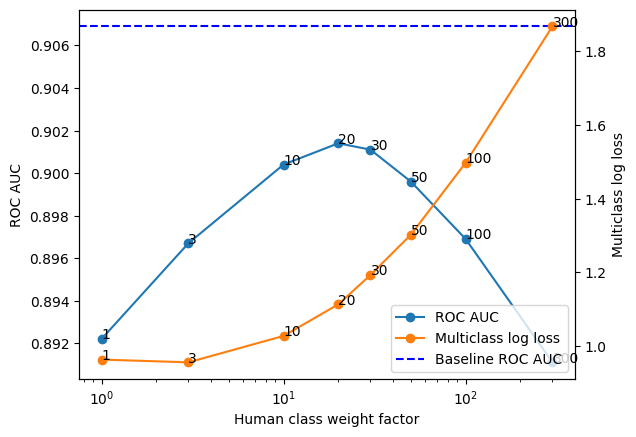

In [47]:
data = [
    [1, 0.8922, 0.9644],
    [3, 0.8967, 0.9570],
    [10, 0.9004, 1.0284],
    [20, 0.9014, 1.1140],
    [30, 0.9011, 1.1932],
    [50, 0.8996, 1.3022],
    [100, 0.8969, 1.4967],
    [300, 0.8911, 1.8659]
]
baseline = 0.9069

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ln1 = ax1.plot([x[0] for x in data], [x[1] for x in data], label='ROC AUC', color='tab:blue', marker='o')
for i, txt in enumerate([f'{x[0]}' for x in data]):
    ax1.annotate(txt, (data[i][0], data[i][1]))

ln2 = ax2.plot([x[0] for x in data], [x[2] for x in data], label='Multiclass log loss', color='tab:orange', marker='o')
for i, txt in enumerate([f'{x[0]}' for x in data]):
    ax2.annotate(txt, (data[i][0], data[i][2]))

ln3 = ax1.axhline(y=baseline, color='b', linestyle='--', label='Baseline ROC AUC')

ax1.set_ylabel('ROC AUC')
ax2.set_ylabel('Multiclass log loss')
ax1.set_xlabel('Human class weight factor')
ax1.set_xscale('log')
lns = ln1 + ln2 + [ln3]
ax1.legend(lns, [l.get_label() for l in lns], loc='lower right')
plt.show()

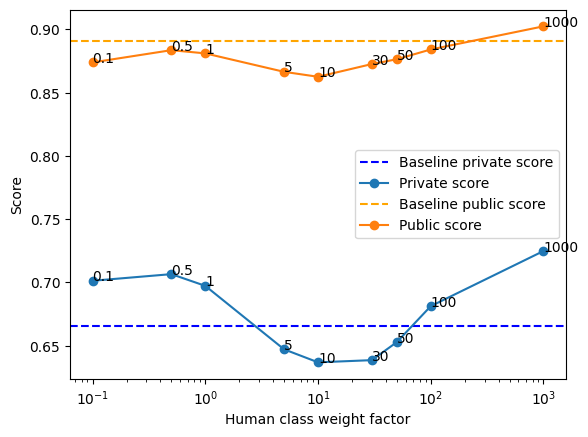

In [53]:
data = [
    [0.1, 0.701310, 0.873958],
    [0.5, 0.7065521, 0.883646],
    [1, 0.697281, 0.881103],
    [5, 0.647095, 0.866519],
    [10, 0.636825, 0.862602],
    [30, 0.638540, 0.872659],
    [50, 0.652778, 0.876469],
    [100, 0.681232, 0.884198],
    [1000, 0.724823, 0.902500]
]

baseline = [0.665908, 0.891065]

fig = plt.figure()

plt.axhline(y=baseline[0], color='b', linestyle='--', label='Baseline private score')
plt.plot([x[0] for x in data], [x[1] for x in data], label='Private score', color='tab:blue', marker='o')
for i, txt in enumerate([f'{x[0]}' for x in data]):
    plt.annotate(txt, (data[i][0], data[i][1]))

plt.axhline(y=baseline[1], color='orange', linestyle='--', label='Baseline public score')
plt.plot([x[0] for x in data], [x[2] for x in data], label='Public score', color='tab:orange', marker='o')
for i, txt in enumerate([f'{x[0]}' for x in data]):
    plt.annotate(txt, (data[i][0], data[i][2]))


plt.xscale('log')
plt.xlabel('Human class weight factor')
plt.ylabel('Score')
plt.legend()
plt.show()